Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2882 - loss: 1.8983 - val_accuracy: 0.4983 - val_loss: 1.4064
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4682 - loss: 1.4694 - val_accuracy: 0.5668 - val_loss: 1.2456
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5254 - loss: 1.3203 - val_accuracy: 0.5977 - val_loss: 1.1421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


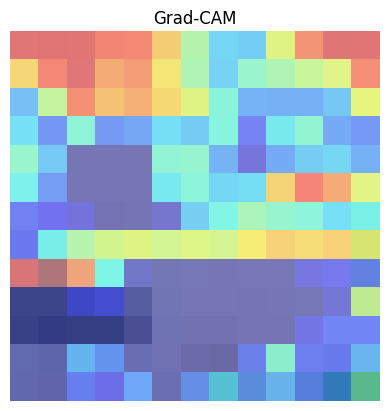

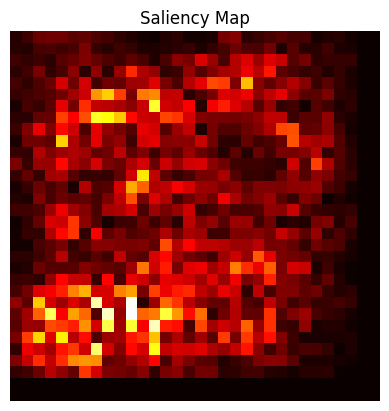

In [1]:
# Step 1: Install TensorFlow (if not already installed)

# Step 2: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

# Step 3: Load and Preprocess CIFAR-10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Step 4: Define Model using Functional API
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', name='conv1')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv2')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
model.fit(x_train, y_train_cat, epochs=3, validation_split=0.2)

# Step 6: Grad-CAM Visualization
img = x_test[1]
img_tensor = tf.expand_dims(img, axis=0)

# Predict once to build model
_ = model.predict(img_tensor)

# Create Grad-CAM model
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer('conv2').output, model.output]
)

# Compute Gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor)
    pred_class = tf.argmax(predictions[0])
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Generate Heatmap
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

# Show Grad-CAM
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Grad-CAM')
plt.show()

# Step 7: Saliency Map
img_tensor = tf.convert_to_tensor(img_tensor)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, img_tensor)[0]
saliency = np.max(np.abs(grads), axis=-1)

# Show Saliency Map
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.title('Saliency Map')
plt.show()


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8360 - loss: 0.5941 - val_accuracy: 0.9650 - val_loss: 0.1284
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9631 - loss: 0.1245 - val_accuracy: 0.9785 - val_loss: 0.0811
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9775 - loss: 0.0781 - val_accuracy: 0.9837 - val_loss: 0.0627


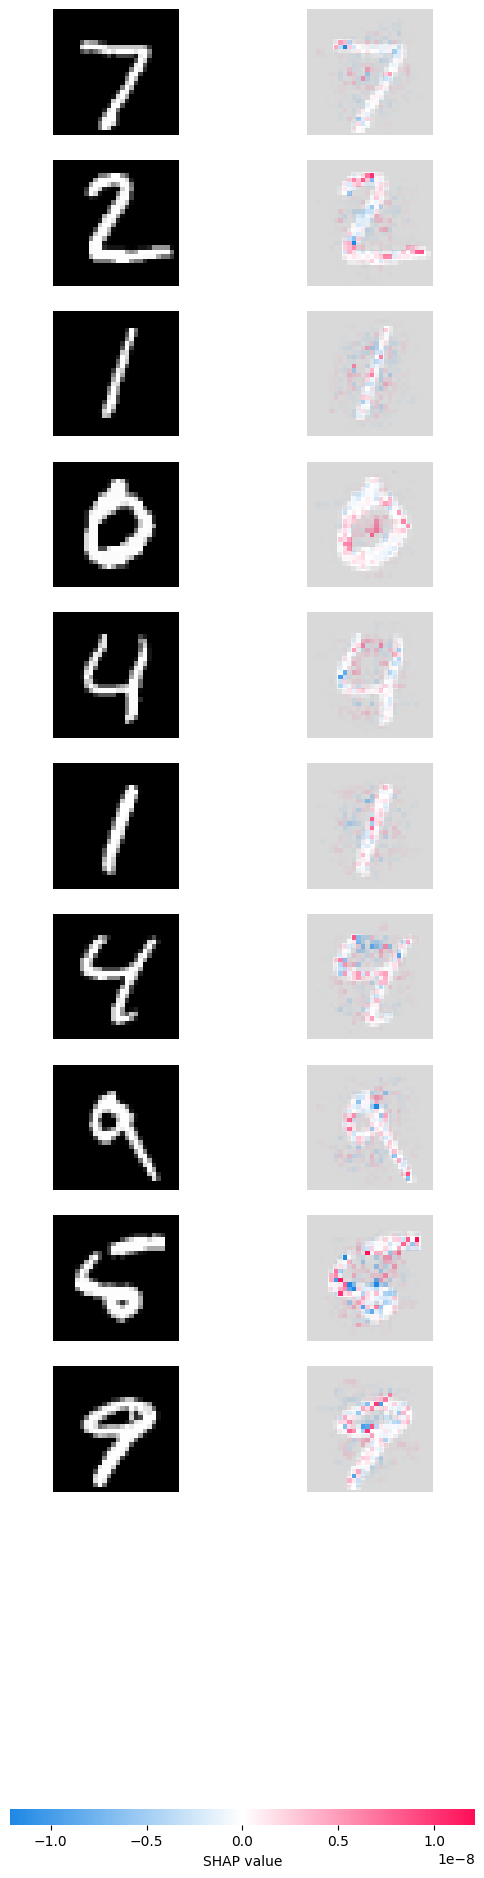

In [2]:
import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt

# Load and preprocess MNIST data
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape data
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

# Prepare SHAP explainer
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# Wrap the model prediction function
explainer = shap.GradientExplainer(model, background)

# Select a few test samples for explanation
test_images = x_test[:10]

# Compute SHAP values
shap_values = explainer.shap_values(test_images)

# Visualize SHAP values
shap.image_plot(shap_values, test_images)
